Projekat 3

Filip Nikolić   
Jovan Dimitrijević

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import matplotlib.pyplot as plt
# Keras Tuner za optimizaciju hiperparametara
from kerastuner import HyperModel
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf  # Potreban za custom loss function

/Users/filipnikolic/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/jc/s6_wfk0j7g57q2c_gstxqzgr0000gn/T/ipykernel_15602/1870456982.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


Priprema i predobrada dataseta

In [2]:
# Učitavanje i čišćenje podataka
data = pd.read_csv('air traffic.csv')

# Konvertovanje stringova u float vrednosti i obrada outlier-a
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace(',', '').astype(float)

# Identifikacija i uklanjanje outlier-a pomoću Z-score
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
data_clean = data[(z_scores < 3).all(axis=1)]

X = data_clean.drop(['Dom_LF', 'Int_LF', 'LF'], axis=1).values
y = data_clean[['Dom_LF', 'Int_LF', 'LF']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizacija podataka
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Custom loss funkcija

In [3]:
# Custom weighted MSE loss function
def weighted_mse_loss(y_true, y_pred):
    # Define weights
    weights = tf.constant([1.0] * (y_pred.shape[-1] - 3) + [10.0, 10.0, 10.0])
    
    # Calculate MSE
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    
    # Apply weights
    weighted_mse = mse * weights
    
    # Return the mean weighted MSE
    return tf.reduce_mean(weighted_mse)

Kreiranje neuronske mreže

In [4]:
class MyFlexibleHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        # First layer with input shape
        model.add(Dense(units=hp.Int('units_input', min_value=8, max_value=512, step=8),
                        activation=hp.Choice('activation_input', ['relu', 'tanh', 'sigmoid']),
                        input_shape=(self.input_shape,)))
        # BatchNormalization layer optional
        if hp.Boolean('batch_normalization_input'):
            model.add(BatchNormalization())
        
        # Additional layers
        for i in range(hp.Int('layers', 1, 5)):  # Flexible number of layers
            model.add(Dense(units=hp.Int(f'units_{i}', 8, 512, step=8),
                            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh', 'sigmoid']),
                            kernel_regularizer=regularizers.l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
            if hp.Boolean(f'batch_normalization_{i}'):
                model.add(BatchNormalization())
            model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.05)))
        
        # Output layer
        model.add(Dense(3, activation='linear'))  # Assuming regression problem with 3 outputs
        # Optimizer choice
        optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
        if optimizer_choice == 'adam':
            optimizer = Adam(learning_rate=hp.Float('lr_adam', 1e-4, 1e-2, sampling='log'))
        elif optimizer_choice == 'sgd':
            optimizer = SGD(learning_rate=hp.Float('lr_sgd', 1e-4, 1e-2, sampling='log'),
                            momentum=hp.Float('momentum_sgd', 0.0, 0.9, step=0.1))
        elif optimizer_choice == 'rmsprop':
            optimizer = RMSprop(learning_rate=hp.Float('lr_rmsprop', 1e-4, 1e-2, sampling='log'))
        
        # Integration of custom loss function along with original choices
        loss_functions = {
            'mean_squared_error': 'mean_squared_error',
            'mean_absolute_error': 'mean_absolute_error',
            'mean_squared_logarithmic_error': 'mean_squared_logarithmic_error',
            'weighted_mse_loss': weighted_mse_loss  # Custom loss function
        }

        # Loss function choice
        loss_choice = hp.Choice('loss_function', list(loss_functions.keys()))
        
        model.compile(optimizer=optimizer, loss=loss_choice)
        return model

hypermodel = MyFlexibleHyperModel(input_shape=X_train_scaled.shape[1])

# Callback for Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

# Callback for Learning Rate Scheduling
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=10,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    min_lr=1e-6  # Lower bound on the learning rate
)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir_el',
    project_name='air_traffic_el'
)

tuner.search(X_train_scaled, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Reloading Tuner from my_dir_el/air_traffic_el/tuner0.json


Vizuelizacija rezultata (najboljeg modela)

2024-03-20 10:30:00.934291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


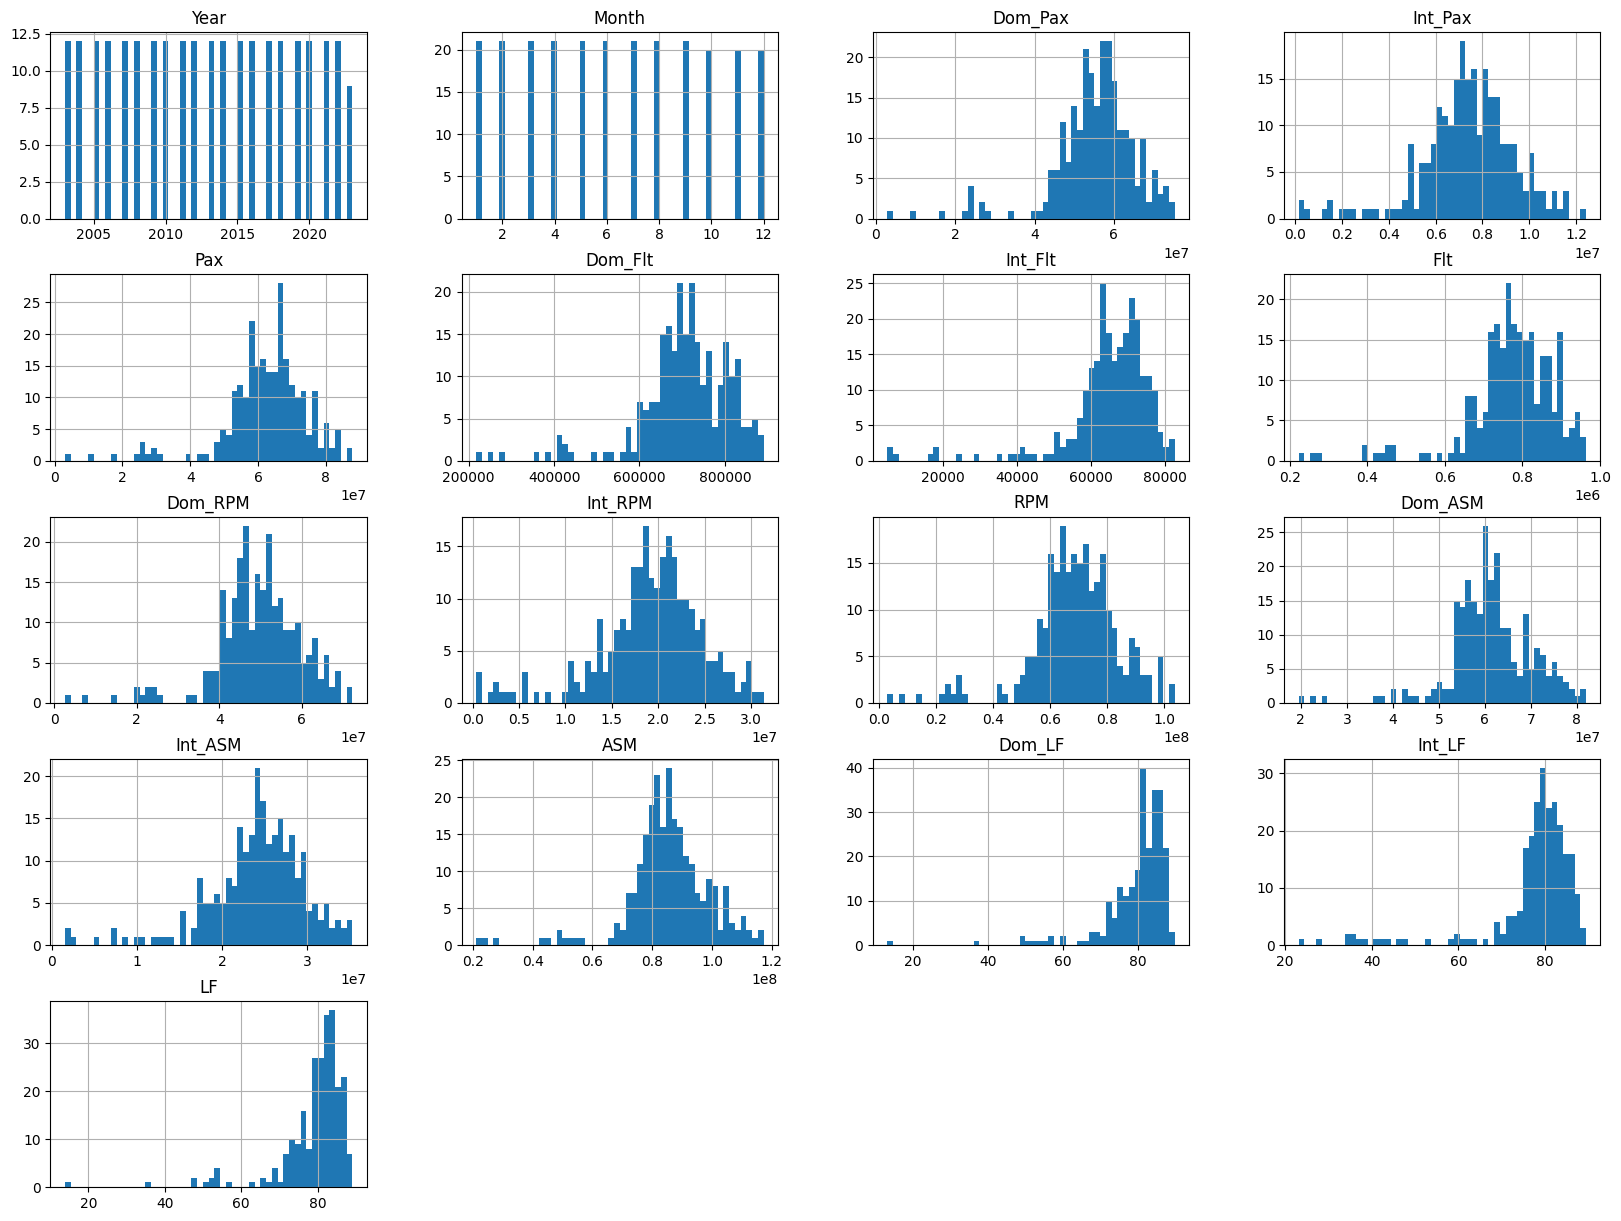

2/2 [==============================] - 0s 3ms/step
Mean Squared Error: 13.074828367524576
R2 Score: 0.6884699997805885
Mean Absolute Error: 2.329043142530653
Root Mean Squared Error: 3.615913213494563


In [5]:
# Najbolji model
best_model = tuner.get_best_models(num_models=1)[0]

# Vizualizacija raspodele vrednosti feature-a
data.hist(bins=50, figsize=(20,15))
plt.show()

# Evaluacija najboljeg modela
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

Vizualizacija feature importance-a i prikaz najboljih hiperparametara

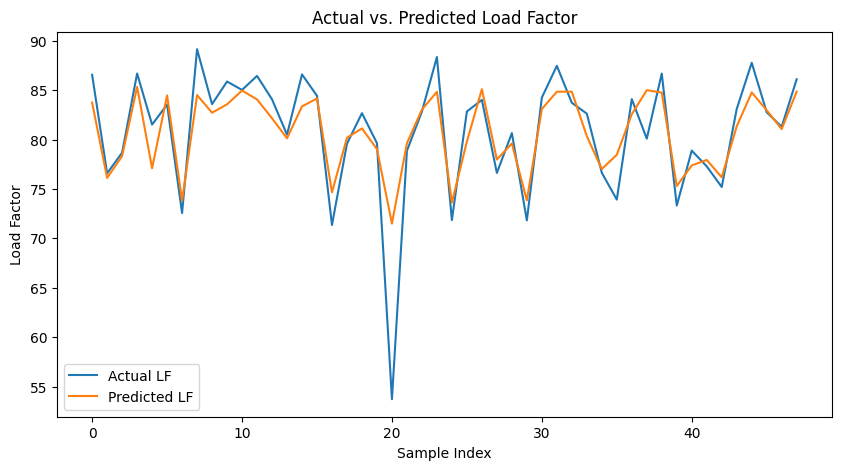

Best hyperparameters:
units_input: 248
activation_input: relu
batch_normalization_input: True
layers: 3
units_0: 96
activation_0: relu
l2: 0.00012260598900591885
batch_normalization_0: True
dropout_0: 0.4
optimizer: adam
lr_adam: 0.007775645935042448
loss_function: mean_squared_logarithmic_error
lr_rmsprop: 0.00186820564517529
units_1: 248
activation_1: tanh
batch_normalization_1: True
dropout_1: 0.15000000000000002
units_2: 232
activation_2: tanh
batch_normalization_2: False
dropout_2: 0.1
units_3: 32
activation_3: relu
batch_normalization_3: False
dropout_3: 0.45
units_4: 88
activation_4: sigmoid
batch_normalization_4: True
dropout_4: 0.25


In [6]:
plt.figure(figsize=(10, 5))
plt.plot(y_test[:, 2], label='Actual LF')
plt.plot(y_pred[:, 2], label='Predicted LF')
plt.title('Actual vs. Predicted Load Factor')
plt.xlabel('Sample Index')
plt.ylabel('Load Factor')
plt.legend()
plt.show()

best_hp = tuner.get_best_hyperparameters()[0]

# Ispisivanje najboljih hiperparametara
print("Best hyperparameters:")
for param in best_hp.space:
    print(f"{param.name}: {best_hp.get(param.name)}")

Treniranje najboljeg modela

Epoch 1/200
5/5 [==============================] - 1s 50ms/step - loss: 0.0448 - val_loss: 0.0430 - lr: 0.0078
Epoch 2/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0442 - val_loss: 0.0426 - lr: 0.0078
Epoch 3/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0439 - val_loss: 0.0424 - lr: 0.0078
Epoch 4/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0440 - val_loss: 0.0420 - lr: 0.0078
Epoch 5/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0437 - val_loss: 0.0418 - lr: 0.0078
Epoch 6/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0428 - val_loss: 0.0414 - lr: 0.0078
Epoch 7/200
5/5 [==============================] - 0s 8ms/step - loss: 0.0423 - val_loss: 0.0412 - lr: 0.0078
Epoch 8/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0422 - val_loss: 0.0408 - lr: 0.0078
Epoch 9/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0417 - val_loss: 0.0405 - lr: 0.0078
Epoch 10/

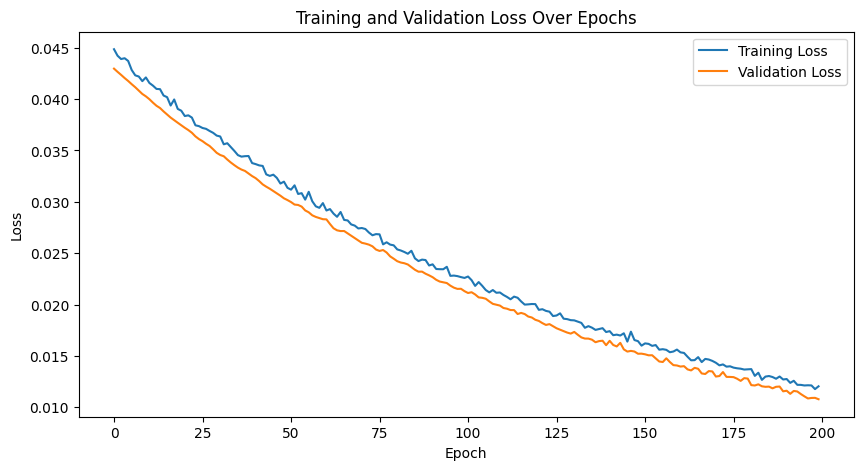

In [7]:
# Ponovo treniramo najbolji model, ovaj put čuvamo istoriju
history = best_model.fit(X_train_scaled, y_train, epochs=200, validation_split=0.2, verbose=1, callbacks=[early_stopping, reduce_lr])

# Vizualizacija funkcije gubitka
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()